In [1]:
!pip install torchvision==0.16.0
!pip install seaborn
# 安装后点击上方 Restart the kernal

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.huaweicloud.com/repository/pypi/simple

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [11]:
# 步骤一：导入相关库
import os
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch_npu.contrib import transfer_to_npu
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# 步骤二：加载数据集
# 2.1 设置参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.01
ACTIVATION = 'relu'   # 可选 'relu' 或 'sigmoid'
OPTIMIZER = 'sgd'     # 可选 'adam' 或 'sgd'
DROPOUT = False
device = 'npu'

# 2.2 数据预处理
transform = transforms.Compose([
    # ToTensor 和 Normalize
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2.3 加载训练集和测试集
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=transform,
    download=True
)
test_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=False,
    transform=transform,
    download=True
)

train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)  # 请在此处编写代码
test_loader = Data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)  # 请在此处编写代码

In [ ]:
# 步骤三：MLP模型的构建
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        input_dim = 28 * 28 
        hidden_dim1 = 512    
        hidden_dim2 = 256   
        output_dim = 10
        
        if ACTIVATION == 'relu':
            act_fn = nn.ReLU()
        elif ACTIVATION == 'sigmoid':
            act_fn = nn.Sigmoid() # 激活函数与Dropout判断
        layers = [
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim1),
            act_fn  # Flatten + Linear + activation
        ]
        if DROPOUT:
            layers.append(nn.Dropout(0.5))  # 添加Dropout层
        layers += [
            nn.Linear(hidden_dim1, hidden_dim2),
            act_fn,
            nn.Linear(hidden_dim2, output_dim) # Linear + activation + output
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

mlp = MLP()  # 实例化并迁移模型到NPU
mlp = mlp.to(device)

In [ ]:
# 步骤四：设置损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失
if OPTIMIZER == 'adam':
    optimizer = optim.Adam(mlp.parameters(), lr=LR)  # Adam优化器
elif OPTIMIZER == 'sgd':
    optimizer = optim.SGD(mlp.parameters(), lr=LR, momentum=0.9)  # SGD优化器

lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LR,
    steps_per_epoch=len(train_loader),
    epochs=EPOCH
)  # OneCycleLR调度器

In [ ]:
# 步骤五：训练模型
train_losses = []
test_accuracies = []

# 5.1 定义训练函数
def train(epoch):
    mlp.train()
    running_loss = 0.0
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # 数据迁移，梯度清零
        outputs = mlp(inputs)
        loss = criterion(outputs, targets)
        loss.backward()  # 前向传播，计算loss，反向传播
        optimizer.step()
        lr_scheduler.step()  # 优化器更新，学习率更新
        running_loss += loss.item()
        epoch_loss += 1  # loss累加与打印

    avg_epoch_loss = running_loss / epoch_loss
    train_losses.append(avg_epoch_loss)  # 平均loss并添加到train_losses

# 5.2 定义测试函数
def test():
    mlp.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = mlp(inputs)
            _, predicted = torch.max(outputs.data, 1)  # 迁移，前向传播，预测
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_preds.append(predicted.cpu()) 
            all_labels.append(targets.cpu())  # 统计正确个数，保存预测和标签
    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# 5.3 开始训练和测试
os.makedirs('./output', exist_ok=True)
for epoch in range(EPOCH):
    train(epoch)  # 调用train函数
    if (epoch + 1) % 2 == 0:
        current_acc, _, _ = test()
        test_accuracies.append(current_acc)
          # 调用test函数，记录准确率

Testing: 100%|██████████| 157/157 [00:02<00:00, 66.47it/s]


Testing: 100%|██████████| 157/157 [00:02<00:00, 63.64it/s]



Final Test Accuracy: 98.28%


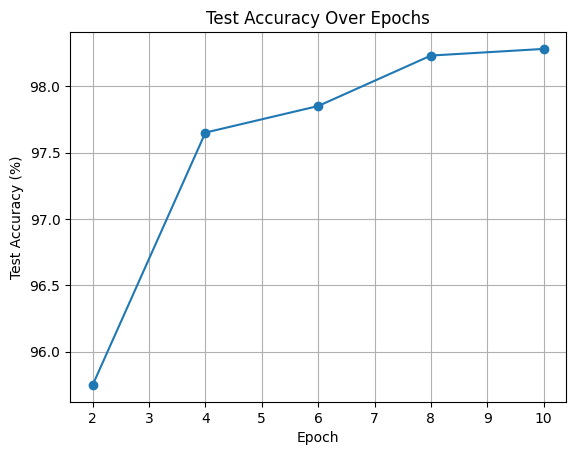

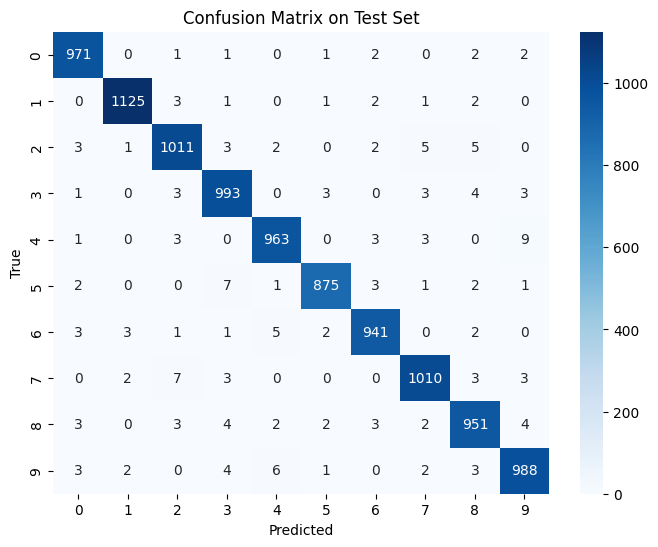

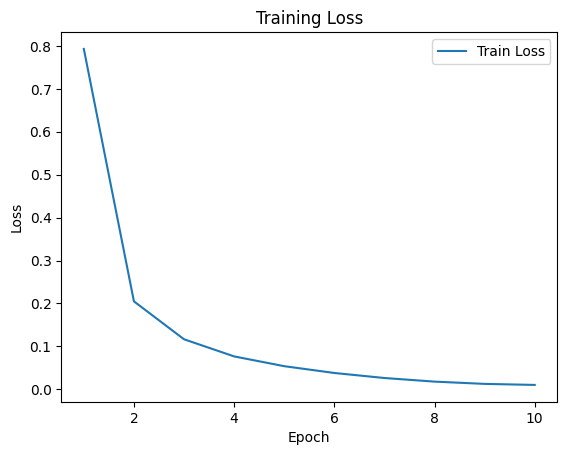

********Prediction Samples********
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
Actual labels:    [7 2 1 0 4 1 4 9 5 9]


In [25]:
# 步骤六：模型评估
# 6.1 最后一次完整测试
final_acc, pred_y, true_y = test()
print(f"\nFinal Test Accuracy: {final_acc:.2f}%")

# 6.2 绘制测试准确率变化曲线
plt.figure()
plt.plot(range(2, EPOCH+1, 2), test_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.savefig('./output/accuracy_curve.png')
plt.show()

# 6.3 绘制混淆矩阵
conf_mat = confusion_matrix(true_y, pred_y)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.savefig('./output/confusion_matrix.png')
plt.show()

# 6.4 绘制训练 loss 曲线图
plt.figure()
plt.plot(range(1, EPOCH+1, 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.savefig('./output/loss_curve.png')
plt.show()

# 6.5 打印前10个样本预测
print('********Prediction Samples********')
print("Predicted labels:", pred_y[:10].numpy())
print("Actual labels:   ", true_y[:10].numpy())

In [ ]:
# 步骤七：保存模型
# 保存模型
model_save_path = './output/mlp_mnist_npu.pth' if device == 'npu' else './output/mlp_mnist_cpu.pth'
torch.save(mlp.state_dict(), model_save_path)

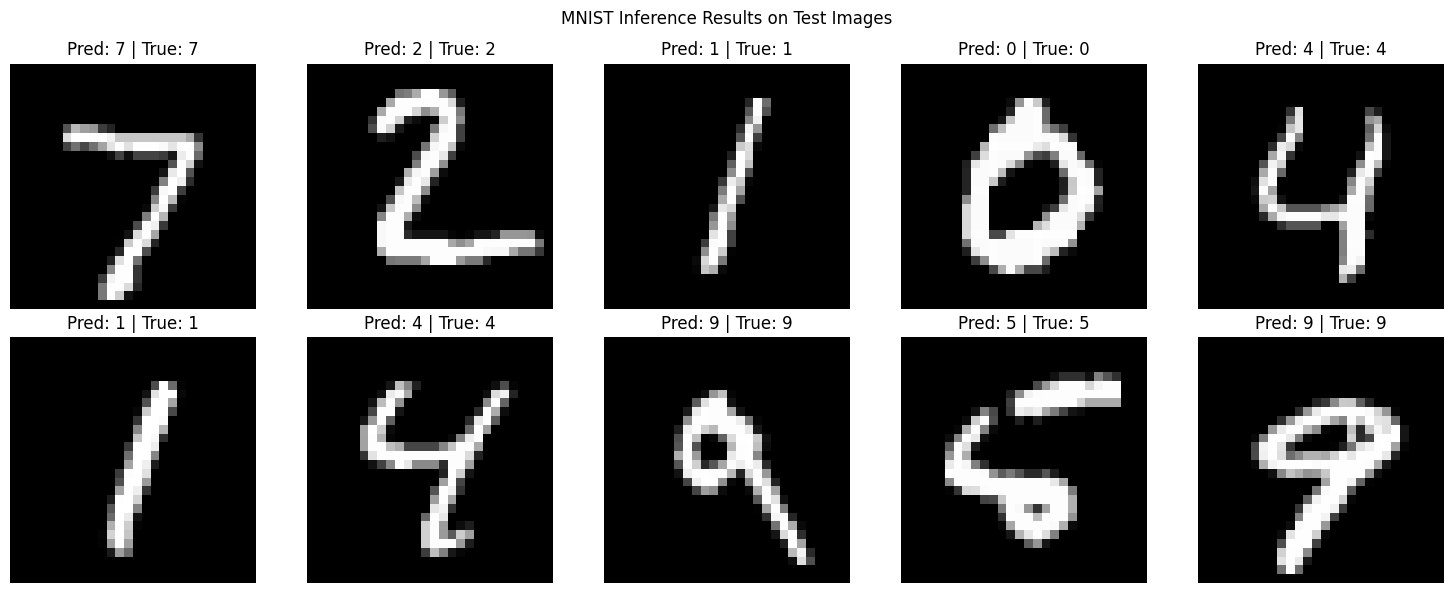

In [ ]:
# 步骤八：推理结果可视化（MNIST专用）
def visualize_mnist_predictions(model, test_loader, device='cpu', num_images=10):
    """
    可视化模型在 MNIST 测试集上的部分预测结果（灰度图）
    """
    model.eval()  # 切换模型为eval模式
    shown = 0
    plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # 将inputs和targets迁移到设备
            outputs = model(inputs)  # 前向传播
            _, predicted = torch.max(outputs.data, 1)  # 获取预测类别

            for i in range(inputs.size(0)):
                if shown >= num_images:
                    break

                img = inputs[i].squeeze().cpu().numpy()  # 获取第i张图像并转为(28,28) numpy格式
                true_label = targets[i].item()  # 获取真实标签
                pred_label = predicted[i].item()  # 获取预测标签

                plt.subplot(2, (num_images + 1) // 2, shown + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"Pred: {pred_label} | True: {true_label}")
                plt.axis('off')
                shown += 1

            if shown >= num_images:
                break

    plt.suptitle("MNIST Inference Results on Test Images")
    plt.tight_layout()
    plt.savefig('./output/mnist_test_predictions.png')
    plt.show()


# 调用推理可视化函数
visualize_mnist_predictions(mlp, test_loader, device=device, num_images=10)